In [1]:
from PIL import Image,ImageFilter
import numpy as np
import matplotlib.pyplot as plt
import os
import pickle
import scipy
import os.path
from scipy.signal import wiener
from scipy.signal import convolve2d
from __future__ import division
import scipy.stats as stats
from matplotlib.colors import LogNorm
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 25}

matplotlib.rc('font', **font)

In [2]:
def ListofFiles(path):
    filelist=[]
    for root, dirs, files in os.walk(path):
        for file in files:
             filelist.append(os.path.join(root,file))
    return filelist

def getImageValues(Files,EventLimit=1):
    if(type(Files) is list):
        values={}
        count=0
        for file in Files:
            img1=Image.open(file)
            imgArray=np.array(img1)
            values[count]=imgArray
            count+=1
            if(EventLimit==count):
                break
        print(f" {count} frames in dictinary ")
    else:
        img1=Image.open(Files)
        values=np.array(img1)
    return values

def AverageIt(data):
    count=0
    Total=0
    for i in range (0,len(data)):
        Total+=data[i]  
        count+=1
    Averaged=Total/count
    values=0
    for i in range (0,len(data)):
        values+=(data[i]-Averaged)**2
        
    stdev=np.sqrt(values/(count-1))    
    print(f"Total Events Averaged is {count}")
    
    return Averaged,stdev

def PlotSideBySide(EL,Background):
    fig, axs = plt.subplots(1, 2,figsize=(15,12))
    BkSubstracted=EL-Background[0]
    axs[0].set_title("BackGround Substracted")
    axs[0].imshow(BkSubstracted,cmap='gray')
    axs[1].set_title("With Background")
    axs[1].imshow(EL,cmap='gray')

    plt.show()

def Plot(EL):
    plt.figure(figsize=(15,12))
    plt.title("Tracks")
    plt.imshow(EL)

    plt.show()
#    https://www.owlnet.rice.edu/~elec539/Projects99/BACH/proj2/wiener.html




def Ppectrum(img,bgn,Title):

    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    print(len(Fourier_Amplitudes_img1))
    ### binning 
    kbins = np.arange(0.5, npix//2+1, 1)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)

    '''ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    ### Mask it
    xlow=25
    xhigh=240
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    

    
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY*(IntegralSig/IntegralBG)
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    weinerNormed[WeinerMask]=0
    weiner[WeinerMask]=0
    WeinerNanMask=np.isnan(weiner)
    weiner[WeinerNanMask]=0
    '''

      #WeinerByForce=(ImgY-BgY)/ImgY
    #WeinerByForceNormed=(np.trapz(ImgY,dx=1)/np.trapz(WeinerByForce,dx=1))*WeinerByForce
    #WeinerByForceNormed[WeinerMask]=0
    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.plot(kvals,Abins/kvals,label="signal")
    plt.plot(kvals,AbinsBackground/kvals,label="Background")
    #plt.plot(kvals,weinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    #plt.axvline(xlow,color='r')
    #plt.axvline(xhigh,color='r',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.axvline(25)
    plt.axvline(512)
  
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    plt.legend()
    plt.show()
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")

def PlotSideBySideWiner(EL,noise=(10,10)):
    fig, axs = plt.subplots(1, 2,figsize=(15,12))
    axs[0].set_title("Actual")
    axs[0].imshow(EL)
    axs[1].set_title("Winer Filtered")
    WinerFiltered=wiener(EL,noise)
    axs[1].imshow(WinerFiltered)

    plt.show()

def getPowerSpectrum(imgs,backgrounds,Name,xlow=100,xhigh=200):
    # take dft
    
    TotalNoisePS=0
    TotalDataPS=0
    imgdata=0
    bgdata=0
    DataCount=0
    BgnCount=0
    Signalhist=np.array([])
    Noisehist=np.array([])
    Filename=Name+".p"
    Values={}

    if(not(os.path.exists(Filename))): 
        for background in backgrounds:
            bgndfft=np.fft.fft2(backgrounds[background])
            bgspecnoise=(np.abs(bgndfft))**2
            TotalNoisePS+=bgspecnoise
            bgdata+=backgrounds[background]
            BgnCount+=1
            #Noisehist=np.append(Noisehist,np.ndarray.flatten(bgspecnoise))

        for  data in imgs :
            datadft = np.fft.fft2(imgs[data])
            signalps=(np.abs(datadft))**2
            TotalDataPS += signalps
            imgdata+=imgs[data]
            DataCount+=1
            #Signalhist=np.append(Signalhist,np.ndarray.flatten(signalps))
        
        AvgNoiseSpec=TotalNoisePS/BgnCount
        AvgDataSpec=TotalDataPS/DataCount
        
        NormAvgNoiseSpec=AvgNoiseSpec/np.max(AvgNoiseSpec)
        NormAvgDataSpec=AvgDataSpec/np.max(AvgDataSpec)
        print(NormAvgDataSpec)
        wiener1 = (NormAvgDataSpec-NormAvgNoiseSpec)/(NormAvgDataSpec)
        
        imgdataAvg=(imgdata/DataCount)
        BgndataAvg=(bgdata/BgnCount)
        Values["imgs"]=imgdataAvg
        Values["bgns"]=BgndataAvg
        Values["PSData"]=AvgDataSpec
        Values["PSBg"]=AvgNoiseSpec
        Values["Wiener2D"]=wiener1
        PickleITDump(Values,Filename)

    else:
        Values=PickleITRead(Filename)
        wiener1=Values["Wiener2D"]
        AvgDataSpec=Values["PSData"]
        AvgNoiseSpec=Values["PSBg"]
        imgdataAvg=Values["imgs"]
        BgndataAvg=Values["bgns"]
        
        NormAvgNoiseSpec=AvgNoiseSpec/np.max(AvgNoiseSpec)
        NormAvgDataSpec=AvgDataSpec/np.max(AvgDataSpec)
        
        wiener1 = (NormAvgDataSpec-NormAvgNoiseSpec)/(NormAvgDataSpec)
        #wiener1 = (NormAvgDataSpec)/(NormAvgDataSpec+NormAvgNoiseSpec)
        
    print(f"Img Dimension --> {AvgNoiseSpec.shape[0]}x{AvgNoiseSpec.shape[1]}" )
    print(wiener1)
    # clip and convert to uint8
    #restored = restored.clip(0,255).astype(np.uint8)

    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('All Tracks')
    ax[0].scatter([245],[225],s=500,color="r",marker="*")

    ax[0].imshow(imgdataAvg,cmap='gray',origin="lower",vmin=np.mean(imgdataAvg),vmax=np.max(imgdataAvg))
    ax[1].set_title('All Background')
    ax[1].imshow(BgndataAvg,cmap='gray',origin="lower",vmin=np.mean(BgndataAvg),vmax=np.max(BgndataAvg))
    plt.show()
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('2D Power Spectrum of Tracks')
    ax[0].imshow(10*np.log10(AvgDataSpec),cmap='gray')
    ax[1].set_title('2D  Power Spectrum of Background')
    ax[1].imshow(10*np.log10(AvgNoiseSpec),cmap='gray')
    plt.show()
    
   
    
    #### Normalizing the 2D
    xx=np.arange(0,512,1)
    pixels=np.meshgrid(xx,xx)
    pixelsR=np.sqrt((pixels[0]-255)**2+(pixels[1]-255)**2)
    MaskX=np.where(np.logical_and(pixelsR>=xlow,pixelsR<=xhigh))
    

    IntegralBGX=np.trapz(AvgNoiseSpec[MaskX],dx=1)
    IntegralSigX=np.trapz(AvgDataSpec[MaskX],dx=1)
    f=(IntegralSigX/IntegralBGX)
    AvgNoiseSpecNormed=AvgNoiseSpec*f
    wiener2=(AvgDataSpec-AvgNoiseSpecNormed)/AvgDataSpec
    #wiener2=(AvgDataSpec)/(AvgDataSpec+AvgNoiseSpecNormed)
    NegativeMask=wiener2<0
    wiener2[NegativeMask]=0
    NormalizedData=np.ndarray.copy(AvgDataSpec)
    NormalizedBgn=np.ndarray.copy(AvgNoiseSpec)
    NormalizedData[MaskX]=0
    NormalizedBgn[MaskX]=0
    fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(30, 20), sharex=True, sharey=True)
    ax[0].set_title('Data')
    ax[0].imshow(10*np.log10(NormalizedData),cmap='gray')
    ax[1].set_title('Background')
    ax[1].imshow(10*np.log10(NormalizedBgn),cmap='gray')
    ax[2].set_title('Normalized Background')
    ax[2].imshow(10*np.log10(AvgNoiseSpecNormed),cmap='gray')
    ax[3].set_title('2D Wiener Filter')
    ax[3].imshow(RemoveInf(10*np.log10(wiener2)),cmap='gray')
    plt.show()
    
    
    
    ##### Plotting 2DPower Spectrum
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(30, 20), sharex=True, sharey=True)
    #ax[0].set_title('2D Power Spectrum of Track ')
    ax[0].imshow(10*np.log10(np.fft.fftshift(AvgDataSpec)),cmap='gray',extent=[-256,256,256,-256])
    ax[0].set_xlabel("kx",fontsize=25,fontweight='bold')
    ax[0].set_ylabel("ky",fontsize=25,fontweight='bold')
    #ax[1].set_title('2D Power Spectrum of Normalized Background ')
    ax[1].imshow(10*np.log10(np.fft.fftshift(AvgNoiseSpecNormed)),cmap='gray',extent=[-256,256,256,-256])
    ax[1].set_xlabel("kx",fontsize=25,fontweight='bold')
    ax[1].set_ylabel("ky",fontsize=25,fontweight='bold')
    #plt.savefig("/home/ilker/CRAB/ShiftedPS_AveragedImages.png")
    plt.show()
    
    
    return wiener2,AvgNoiseSpec,AvgDataSpec,BgndataAvg,imgdataAvg,f,AvgNoiseSpecNormed

def PlotSinglePowerSpect(data,background,title):
  
    datafreqs=np.fft.fftfreq(data.shape[0])
    
    ps=np.ndarray.flatten(data)
    psnoise=np.ndarray.flatten(background)

    idx1 = np.argsort(datafreqs)
    plt.plot(datafreqs[idx1],ps[idx1],label="signal")
    plt.plot(datafreqs[idx1],psnoise[idx1],label="bgn")
    plt.title(title)
    plt.xlabel("Freq(Hz)")
    plt.ylabel("PowerSpec")
    plt.legend()
    plt.loglog()
    plt.show()

    
def PickleITDump(data,fileName):
    with open(fileName,'wb') as f:
        pickle.dump(data,f)
        
def PickleITRead(fileName):
    
    with open(fileName,'rb') as f:
        data=pickle.load(f)
    return data
    
def RadialFilterv2(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    MaskOut=r>=radius    
    ones=np.ones(r.shape)
    ones[MaskOut]=0
    positions=np.where(MaskIn)
  
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))


    Wiener1d=np.array([])

    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
        
    ones[MaskIn]=Wiener1d
    
    return ones


#########  Using guide from following web page to obtaine power spectrum
####   https://bertvandenbroucke.netlify.app/2019/05/24/computing-a-power-spectrum-in-python/
    
def PpectrumNormed(img,bgn,Title,file,xlow=25,xhigh=256,ZeroOut=False,ReadFile=True):
    if(file and ReadFile):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
    
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
    ## Normalize it
    knrm=np.sqrt(kfreq2D[0]**2+kfreq2D[1]**2)

    ## Convert it to 1d array
    knrm=knrm.flatten()
    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    #print(len(Fourier_Amplitudes_img1))
    ### binning 
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    Abins, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackground, _, _ = stats.binned_statistic(knrm, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    Abins *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackground *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=Abins/kvals
    BgY=AbinsBackground/kvals
    
    ### Mask it
    
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY *(IntegralSig/IntegralBG)
    
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    if(ZeroOut):
        weinerNormed[WeinerMask]=0
        weiner[WeinerMask]=0

    
    #### Set Negative Values to Zero
    NegativeMask=weiner<0
    weinerNormed[NegativeMask]=0
    weiner[NegativeMask]=0


    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.figure(figsize=(12,8),dpi=300)
    plt.plot(kvals,ImgY,label="Signal")
    plt.plot(kvals,BgNormed,label="Normalized Background")
    plt.plot(kvals,BgY,label="Background")

    #plt.plot(kvals,weinerNormed,label="1D Wiener")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(xlow,color='b')
    plt.axvline(xhigh,color='b',label="Normalization Window")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    Newkvals=np.arange(1,513,1)
    NewImgY=ImgY
    NewImgY=np.append(NewImgY,np.flip(ImgY))
    
    NewBgNormed=BgNormed
    NewBgNormed=np.append(NewBgNormed,np.flip(BgNormed))
    NewweinerNormed=weinerNormed
    NewweinerNormed=np.append(NewweinerNormed,np.flip(weinerNormed))
    Newweiner=weiner
    Newweiner=np.append(Newweiner,np.flip(weiner))

    plt.figure(figsize=(15,12),dpi=300)
    plt.plot(Newkvals,NewImgY,label="Signal")
    plt.plot(Newkvals,NewBgNormed,label="BackgroundNormed")
    #plt.plot(Newkvals,NewweinerNormed,label="Weiner")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.semilogy()
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    if(ReadFile):
        Values["Wiener1D"]=weiner
        PickleITDump(Values,file)
    return Newweiner,weiner
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")
    
def Wiener2x1DNormed(img,bgn,Title,file=" ",xlow=25,xhigh=200,ylow=25,yhigh=200,ZeroOut=False,ReadFile=True):
    if(file and ReadFile):
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
    
    npix=img.shape[0]

    ## Obtain the freq
    kfreq=np.fft.fftfreq(npix)*npix

    ## Create a meshgrid
    kfreq2D=np.meshgrid(kfreq,kfreq)
 

    ## Convert it to 1d array
    kfreqX=kfreq2D[0].flatten()
    kfreqY=kfreq2D[1].flatten()

    Fourier_Amplitudes_img1=img.flatten()
    Fourier_Amplitudes_background=bgn.flatten()
    #print(len(Fourier_Amplitudes_img1))
    ### binning 
    
    kbins = np.arange(0.5, npix//2+1, 1.)
    #kbins = np.arange(1, npix, 1.)

    kvals = 0.5 * (kbins[1:] + kbins[:-1])
    
    ### Getting Wiener Filter in  the X
    AbinsX, _, _ = stats.binned_statistic(kfreqX, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackgroundX, _, _ = stats.binned_statistic(kfreqX, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    AbinsX *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackgroundX *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgX=AbinsX/kvals
    BgX=AbinsBackgroundX/kvals
    
    
    
    ### Remove Any nan value
    ImgXNanMask=np.isnan(ImgX)
    BgXNamMask=np.isnan(BgX)
    #ImgX[ImgXNanMask]=0
    #BgX[BgXNamMask]=0
    ### Integrate between xlow and xhigh
    
    MaskX=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    IntegralBGX=np.trapz(BgX[MaskX],dx=1)
    IntegralSigX=np.trapz(ImgX[MaskX],dx=1)
    BgNormedX=BgX *(IntegralSigX/IntegralBGX)
    
    
    wienerX=(ImgX-BgNormedX)/ImgX
    wienerXNanMask=np.isnan(wienerX)
    wienerX[wienerXNanMask]=0
  
    wienerNormedX=(np.trapz(ImgX[:-1],dx=1)/np.trapz(wienerX[:-1],dx=1))*wienerX
    wienerMaskX=kvals>=xlow
    
    
    ### Getting the filter in the Y direction
    
  
    AbinsY, _, _ = stats.binned_statistic(kfreqY, Fourier_Amplitudes_img1,
                                         statistic = "mean",
                                         bins = kbins)
    AbinsBackgroundY, _, _ = stats.binned_statistic(kfreqY, Fourier_Amplitudes_background,
                                         statistic = "mean",
                                         bins = kbins)
    
    AbinsY *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
 
    
    AbinsBackgroundY *= np.pi * (kbins[1:]**2 - kbins[:-1]**2)
   

    ImgY=AbinsY/kvals
    BgY=AbinsBackgroundY/kvals
    
     ### Remove Any nan value
    ImgYNanMask=np.isnan(ImgY)
    BgYNamMask=np.isnan(BgY)
    #ImgY[ImgYNanMask]=0
    #BgY[BgYNamMask]=0
    
    ### Integrate between ylow and yhigh
    
    MaskY=np.where(np.logical_and(kvals>=ylow,kvals<=yhigh))
    IntegralBGY=np.trapz(BgY[MaskY],dx=1)
    IntegralSigY=np.trapz(ImgY[MaskY],dx=1)
    BgNormedY=BgY *(IntegralSigY/IntegralBGY)

   
    wienerY=(ImgY-BgNormedY)/ImgY
    
    wienerYNanMask=np.isnan(wienerY)
    wienerY[wienerYNanMask]=0
    

    wienerNormedY=(np.trapz(ImgY[:-1],dx=1)/np.trapz(wienerY[:-1],dx=1))*wienerY

    wienerMaskY=kvals>=ylow
    
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    if(ZeroOut):
        wienerNormedX[wienerMaskX]=0
        wienerX[wienerMaskX]=0
        
        wienerNormedY[wienerMaskY]=0
        wienerY[wienerMaskY]=0


    
    #### Set Negative Values to Zero
    NegativeMaskX=wienerX<0
    ##wienerNormedX[NegativeMaskX]=0
    wienerX[NegativeMaskX]=0
    
    NegativeMaskY=wienerY<0
    wienerNormedY[NegativeMaskY]=0
    wienerY[NegativeMaskY]=0



    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.figure(figsize=(12,8),dpi=300)
    plt.plot(kvals,ImgX,label="signalX")
    plt.plot(kvals,BgNormedX,label="BackgroundNormedX")
    plt.plot(kvals,BgX,label="BackgroundX")

    plt.plot(kvals,wienerNormedX,label="wienerX")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(xlow,color='b')
    plt.axvline(xhigh,color='b',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    plt.figure(figsize=(12,8),dpi=300)
    plt.plot(kvals,ImgY,label="signalY")
    plt.plot(kvals,BgNormedY,label="BackgroundNormedY")
    plt.plot(kvals,BgY,label="BackgroundY")
    plt.plot(kvals,wienerNormedY,label="wienerY")

    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    plt.loglog()
    plt.axvline(ylow,color='b')
    plt.axvline(yhigh,color='b',label="IntegrationWindow")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title("WienerY")
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    plt.show()
    
    if(ReadFile):
        Values["Wiener1DX"]=wienerX
        Values["Wiener1DY"]=wienerY

        PickleITDump(Values,file)
        

  
    wienerX=np.append(wienerX,np.flip(wienerX))
    wienerY=np.append(wienerY,np.flip(wienerY))
    return wienerX,wienerY
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")    

def gkern(l=5, sig=10., eta=2):
    """\
    creates normally distributed kernel with side length `l`, a sigma of `sig`, and a normal shape `eta`
    """
    ax = np.linspace(-(l - 1) / 2., (l - 1) / 2., l)
    gauss = np.exp(-0.5 * np.abs(ax)**eta / np.abs(sig)**eta)
    kernel = np.outer(gauss, gauss)
#     norm = np.linalg.norm(kernel)
    norm = np.sum(kernel)
    return kernel / norm

#############
# The PE vals looks in a raw tiff file, it readin all of the symbols and
# splits where the info about the camara settings are
# it returns 2 values that are used in converting the adc counts to PE
#############
def PE_Vals(FILE):
    with open(FILE, encoding="utf8", errors="ignore") as f:
        contents = f.read()
    contents = contents.split("Created by Hamamatsu Inc.")[1].split('\n')
    for line in contents:
        if 'eOffset1' in line:
            eOffset = float(line.split("eOffset1 = ")[1])
        elif 'eCoeff1' in line:
            eCoeff = float(line.split("eCoeff1 = ")[1])
    return eOffset, eCoeff

#############
# This takes the raw tiff file and crops it to the proper shape and converts
# the adc counts into PE
#############
def Image_Converter(FILE,eOffset,eCoeff,Xindex,Yindex,Row,Col):
    TestImage = Image.open(FILE)
    Testspot = np.array(TestImage)[Yindex-Row:Yindex+Row+1,Xindex-Col:Xindex+Col+1]
    Shape = Testspot.shape[0]
    eCoeffM = eCoeff*np.ones(Shape**2).reshape((Shape,Shape))
    eOffsetM = eOffset*np.ones(Shape**2).reshape((Shape,Shape))
    Testspot = eCoeffM*(Testspot - eOffsetM)
    TestImage.close()
    return Testspot
Row    = int(256)
Col    = Row
Yindex = int(256)
Xindex = int(256)


#### Radial Wiener Filter

def RadialFilter(wiener,size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.zeros(r.shape)
    print("MaskIn")
    print(MaskIn)
    positions=np.where(MaskIn)
    
    print("Mask IN Positions")
    print(positions)
    print("r from Mesh Grid")
    print(r)
    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    
    print("PositionsR")
    print(positionR)

    Wiener1d=np.array([])
    for i in positionR:
        Wiener1d=np.append(Wiener1d,wiener[int(i)])
    ones[MaskIn]=Wiener1d
    print("Values with MaskIN")
    print(ones[MaskIn])
    return ones
    
    
### Radial obtained Power Spectrum
def RadialAverage(pws,radius,center=None):
    xp=np.arange(pws.shape[0])
    yp=np.arange(pws.shape[0])
    xx,yy=np.meshgrid(xp,yp)
    pws=np.fft.fftshift(pws)
    if not center:
        center=[pws.shape[0]/2,pws.shape[0]/2]
    R=np.sqrt((xx-center[0])**2+(yy-center[1])**2)
    
    radial = lambda r:pws[(R>=r-0.5) & (R<r+0.5)].mean()
    r=np.arange(1,radius,1)
    PWS1D=np.vectorize(radial)(r)
    return PWS1D

    
def PpectrumRadial(img,bgn,Title,file,xlow=25,xhigh=256,ZeroOut=False,ReadFile=True):
    if(file and ReadFile):
        file=file+"_radial.p"
        Values=PickleITRead(file)
        img=Values["PSData"]
        bgn=Values["PSBg"]
    
    ## Obtaining the 1D Power Spectrum using Radial Average
    ImgY=RadialAverage(img,256)
    BgY=RadialAverage(bgn,256)
    
    kvals=np.arange(0,len(ImgY),1)
    ### Mask it
    
    Mask=np.where(np.logical_and(kvals>=xlow,kvals<=xhigh))
    IntegralBG=np.trapz(BgY[Mask],dx=1)
    IntegralSig=np.trapz(ImgY[Mask],dx=1)
    BgNormed=BgY *(IntegralSig/IntegralBG)
    
    
    weiner=(ImgY-BgNormed)/ImgY
    weinerNormed=(np.trapz(ImgY,dx=1)/np.trapz(weiner,dx=1))*weiner
    WeinerMask=kvals>=xlow
    
    #weinerNormed[WeinerMask]=0.5
    #weiner[WeinerMask]=0.5
    if(ZeroOut):
        weinerNormed[WeinerMask]=0
        weiner[WeinerMask]=0

    
    #### Set Negative Values to Zero
    NegativeMask=weiner<0
    weinerNormed[NegativeMask]=0
    weiner[NegativeMask]=0


    print(f"Minimum kval = {min(kvals)} and Maximum kval= {max(kvals)}")
    plt.figure(figsize=(12,12),dpi=300)
    plt.plot(ImgY,label="Signal")
    plt.plot(BgNormed,label="Normalized Background")
    #plt.plot(BgY,label="Background")
    

    #plt.plot(weinerNormed,label="1D Wiener")
    plt.loglog()
    #plt.plot(kvals,WeinerByForceNormed,label="Forced",color='y')
    #plt.axvline(xlow,color='b')
    #plt.axvline(xhigh,color='b',label="Normalization Window")
    #print((Abins/kvals))
    #print(kvals)
    
    plt.title(Title)
    plt.xlabel("$k$")
    plt.ylabel("$P(k)$")
    plt.tight_layout()
    #plt.ylim(1e5)
    plt.legend()
    
    #plt.savefig("/home/ilker/CRAB/WienerR.png")

    plt.show()
   
    if(ReadFile and file):
        Values["Wiener1D"]=weiner
        PickleITDump(Values,file)
        
    return weiner,ImgY,BgNormed
    #plt.savefig("img1_power_spectrum.png", dpi = 300, bbox_inches = "tight")

def DrawCircle(centerx,centery,r,pixelSize,amount):
    x=np.arange(0,pixelSize,1)
    xx,yy=np.meshgrid(x,x)
    rr=np.sqrt((xx-centerx)**2 + (yy-centery)**2)
    print(rr.shape)
    values=np.ones(rr.shape)*-1
    plt.figure(figsize=(12,8),dpi=300)
    count=0
    plt.title("Radial Average")
    #plt.xlim(0,512)
    #plt.ylim(0,512)
    print(r)
    for i in r:
        RadiusMask=(rr>=i-0.5)  & (rr<i+0.5)
        values[RadiusMask]=i
        if (count>=amount):
            break;
        count+=1
    plt.contourf(x,x,values,cmap='viridis',levels=r)
    plt.xlabel("kx")
    plt.ylabel("ky")
    plt.colorbar(label="k")
    plt.show()

    
def RemoveInf(Img):
    InfinityMask=np.isinf(Img)
    FiniteMask=np.isfinite(Img)
    NanMask=np.isnan(Img)
    minimum=np.min(Img[FiniteMask])
    Img[NanMask]=minimum
    Img[InfinityMask]=minimum
    return Img


### This is for the radial masking 

#### Radial Wiener Filter

def HardRadialLowPass(size,xcenter,ycenter,radius):
    xx=np.linspace(0,size,size)
    grid=np.meshgrid(xx,xx)
    r=np.round(np.sqrt((grid[0]-xcenter)**2+(grid[1]-ycenter)**2))
    MaskIn=r<radius
    ones=np.ones(r.shape)
    positions=np.where(MaskIn)
    

    positionR=np.floor(np.sqrt((positions[0]-xcenter)**2+(positions[1]-ycenter)**2))
    


    thefilter=np.array([])
    for i in positionR:
        thefilter=np.append(thefilter,0)
    ones[MaskIn]=thefilter
    return ones
 

In [3]:
Events=PickleITRead("imgs.p")

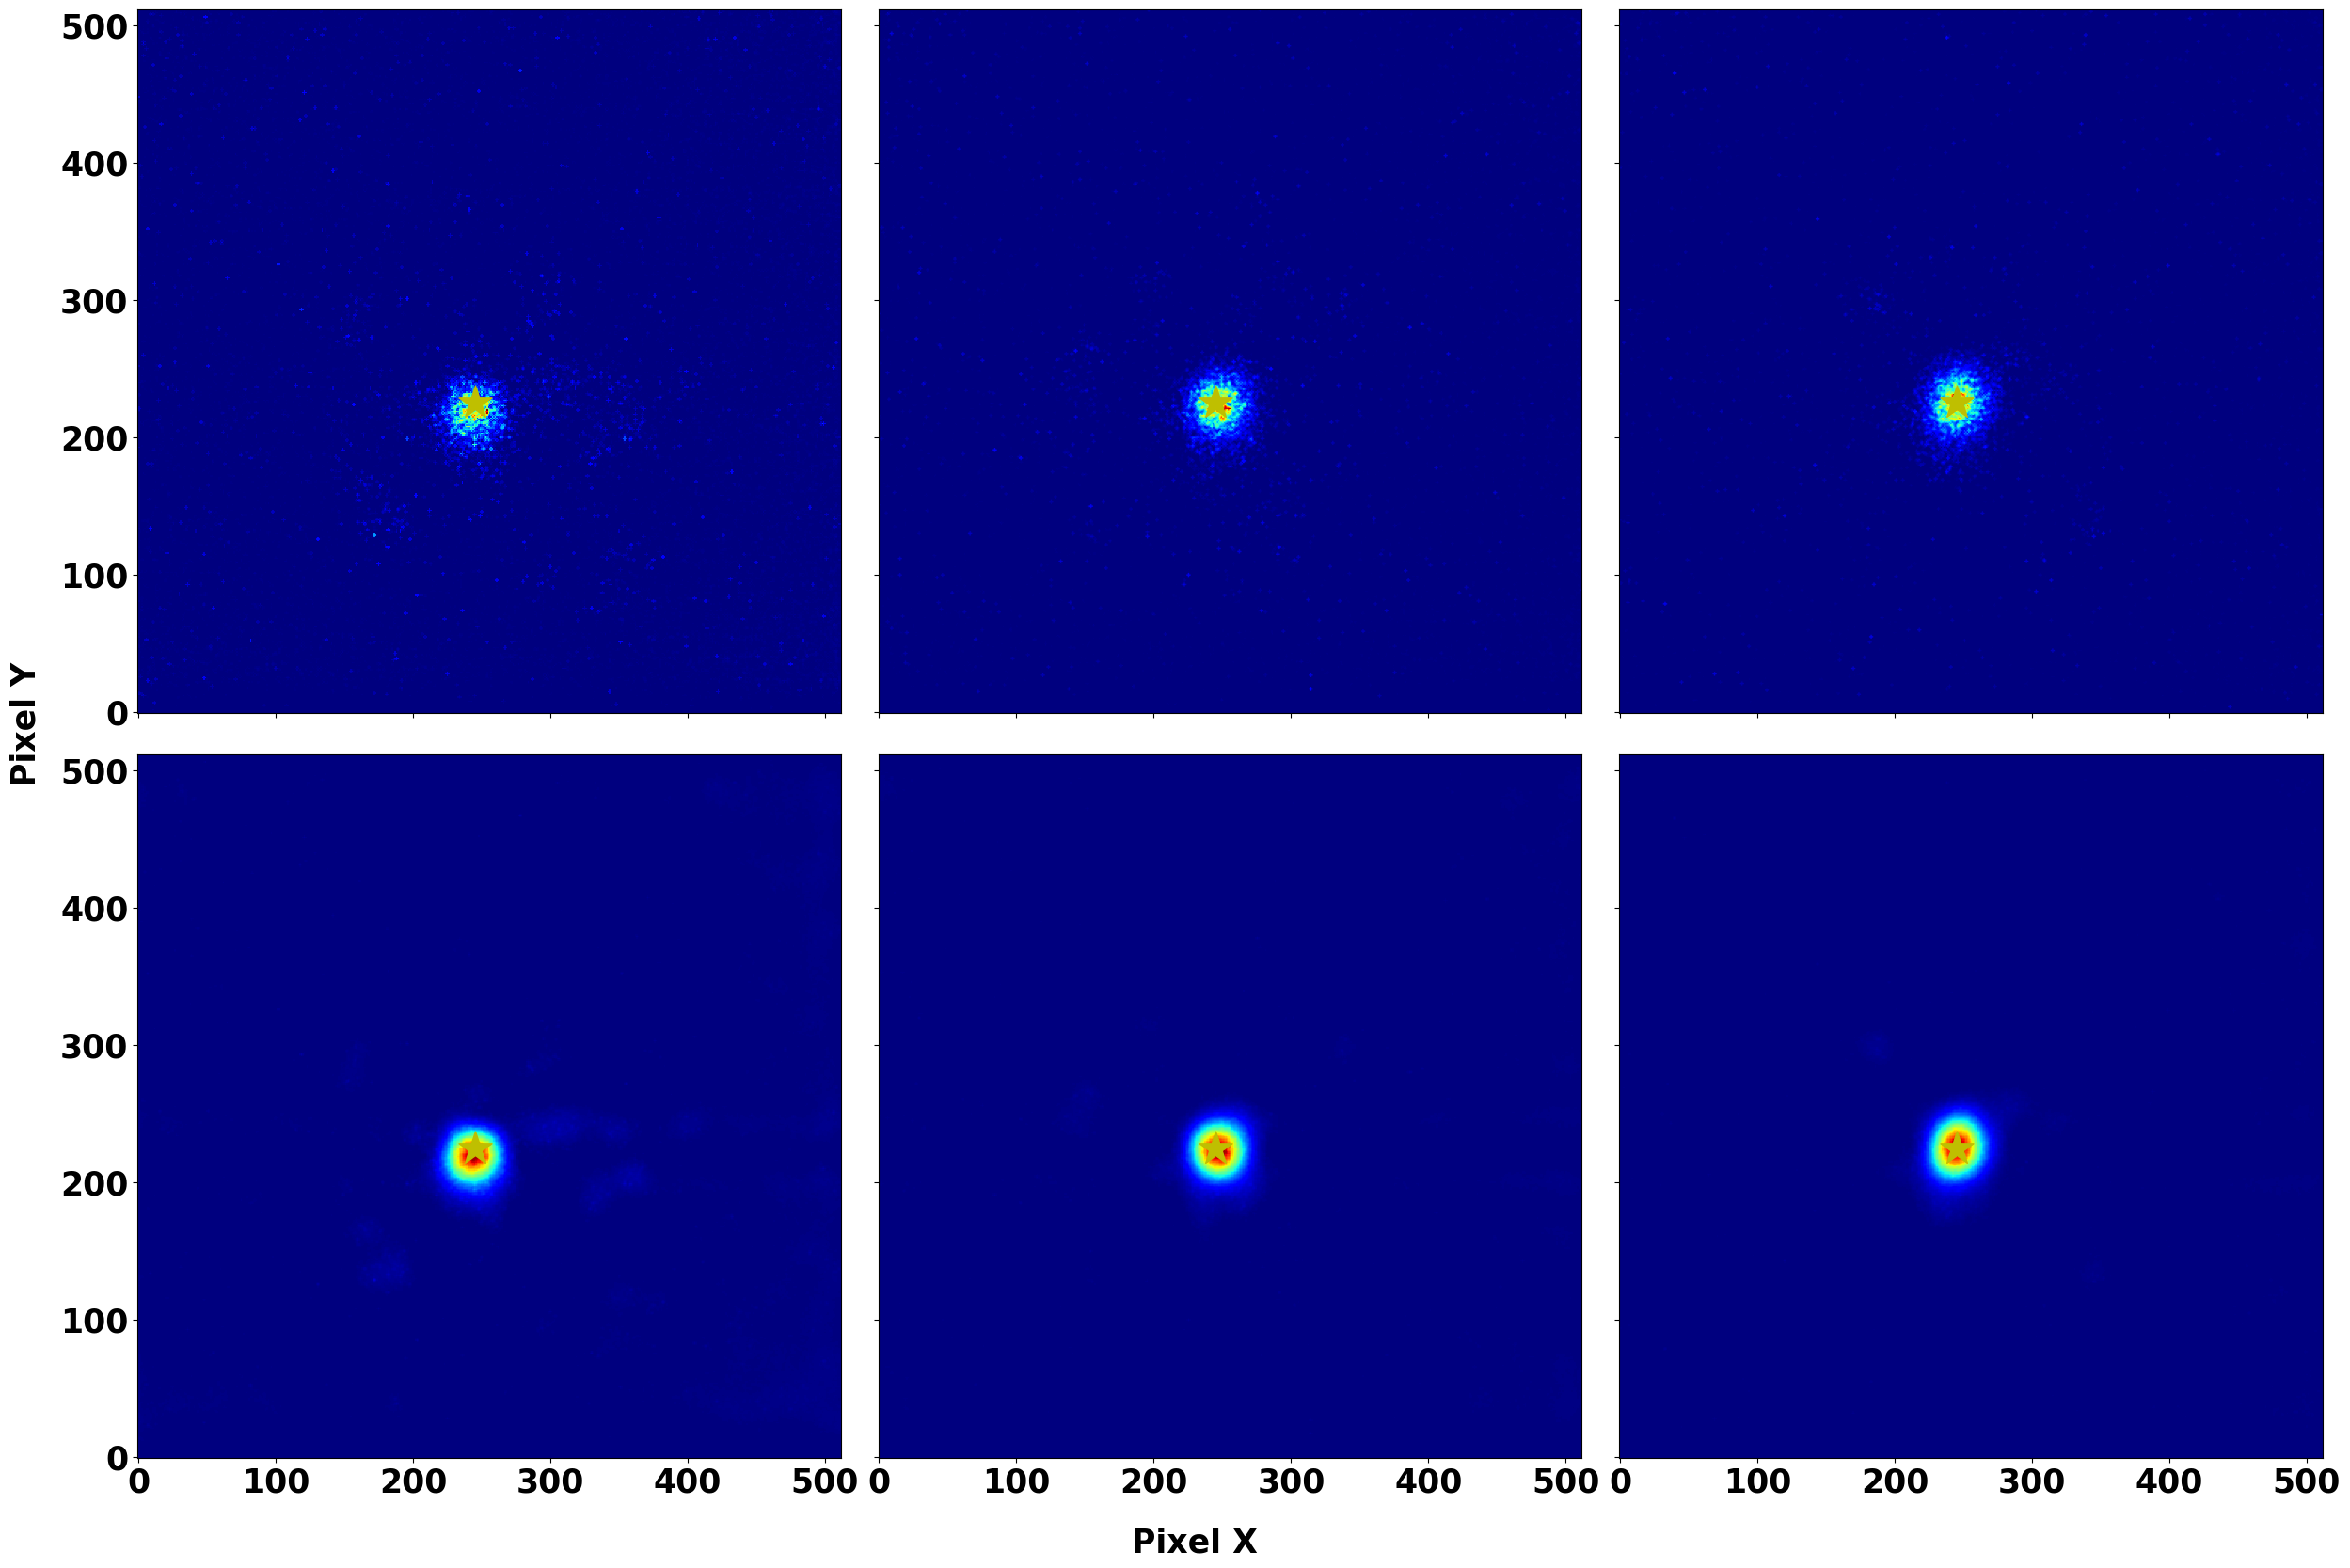

In [5]:
### Alphas
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20), sharex=True, sharey=True)
fig.text(0.5, 0.06, 'Pixel X', ha='center')
fig.text(0.08, 0.5, 'Pixel Y', va='center', rotation='vertical')

#### alphas
ax[0][0].imshow(Events["Alphas"][0],cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(Events["Alphas"][0])), vmax=np.max(Events["Alphas"][0]))
ax[0][1].imshow(Events["Alphas"][1],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Alphas"][1])), vmax=np.max(Events["Alphas"][1]))
ax[0][2].imshow(Events["Alphas"][2],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Alphas"][2])), vmax=np.max(Events["Alphas"][2]))
for i in range(0,3):
    ax[0][i].scatter([245],[225],s=700,color="y",marker="*")
fftimg=np.fft.fft2(Events["Alphas"][0])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][0].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Alphas"][1])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][1].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Alphas"][2])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][2].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))

for i in range(0,3):
    ax[1][i].scatter([245],[225],s=700,color="y",marker="*")

plt.subplots_adjust(wspace=0.05, hspace=0.06)
#fig.savefig("/home/ilker/Desktop/CRAB/Muons.png",bbox_inches='tight')



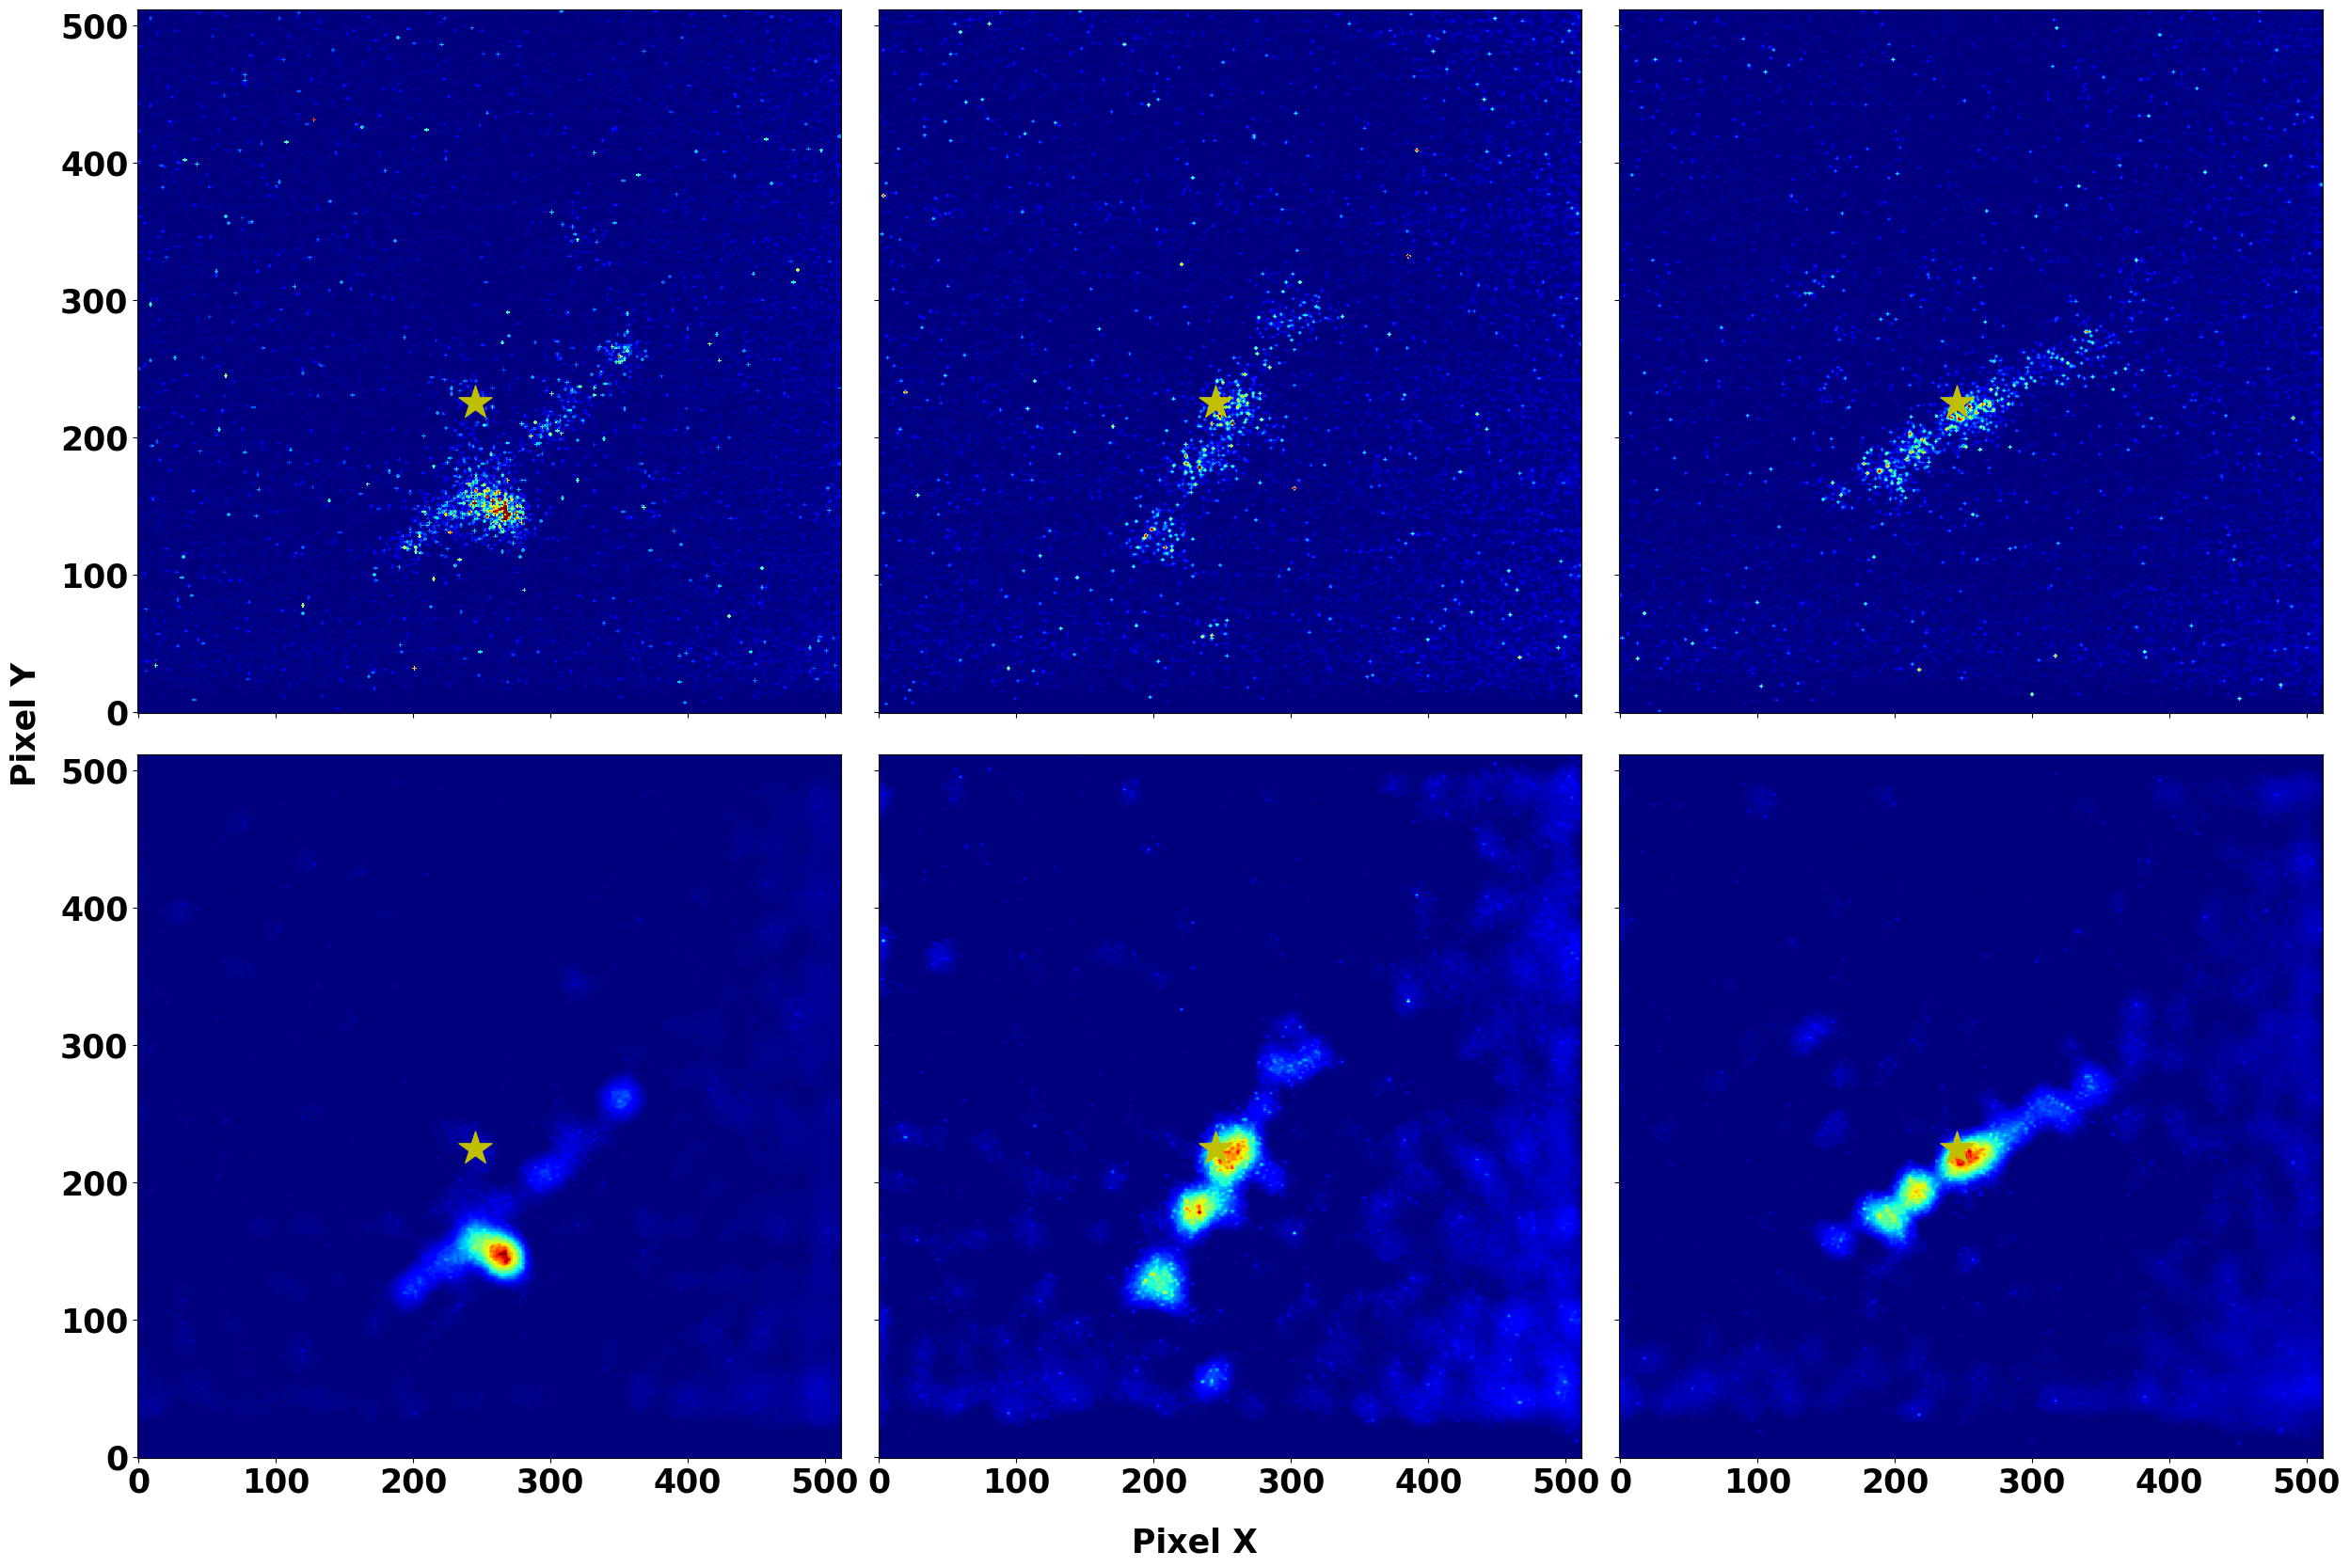

In [7]:
##### Muons
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20), sharex=True, sharey=True)
fig.text(0.5, 0.06, 'Pixel X', ha='center')
fig.text(0.08, 0.5, 'Pixel Y', va='center', rotation='vertical')

#### alphas
ax[0][0].imshow(Events["Muons"][0],cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(Events["Muons"][0])), vmax=np.max(Events["Muons"][0])*0.85)
ax[0][1].imshow(Events["Muons"][1],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Muons"][1])), vmax=np.max(Events["Muons"][1])*0.95)
ax[0][2].imshow(Events["Muons"][2],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Muons"][2])), vmax=np.max(Events["Muons"][2])*0.95)
for i in range(0,3):
    ax[0][i].scatter([245],[225],s=700,color="y",marker="*")
fftimg=np.fft.fft2(Events["Muons"][0])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][0].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Muons"][1])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][1].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Muons"][2])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][2].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))

for i in range(0,3):
    ax[1][i].scatter([245],[225],s=700,color="y",marker="*")

plt.subplots_adjust(wspace=0.05, hspace=0.06)
#fig.savefig("/home/ilker/Desktop/CRAB/Muons.png",bbox_inches='tight')



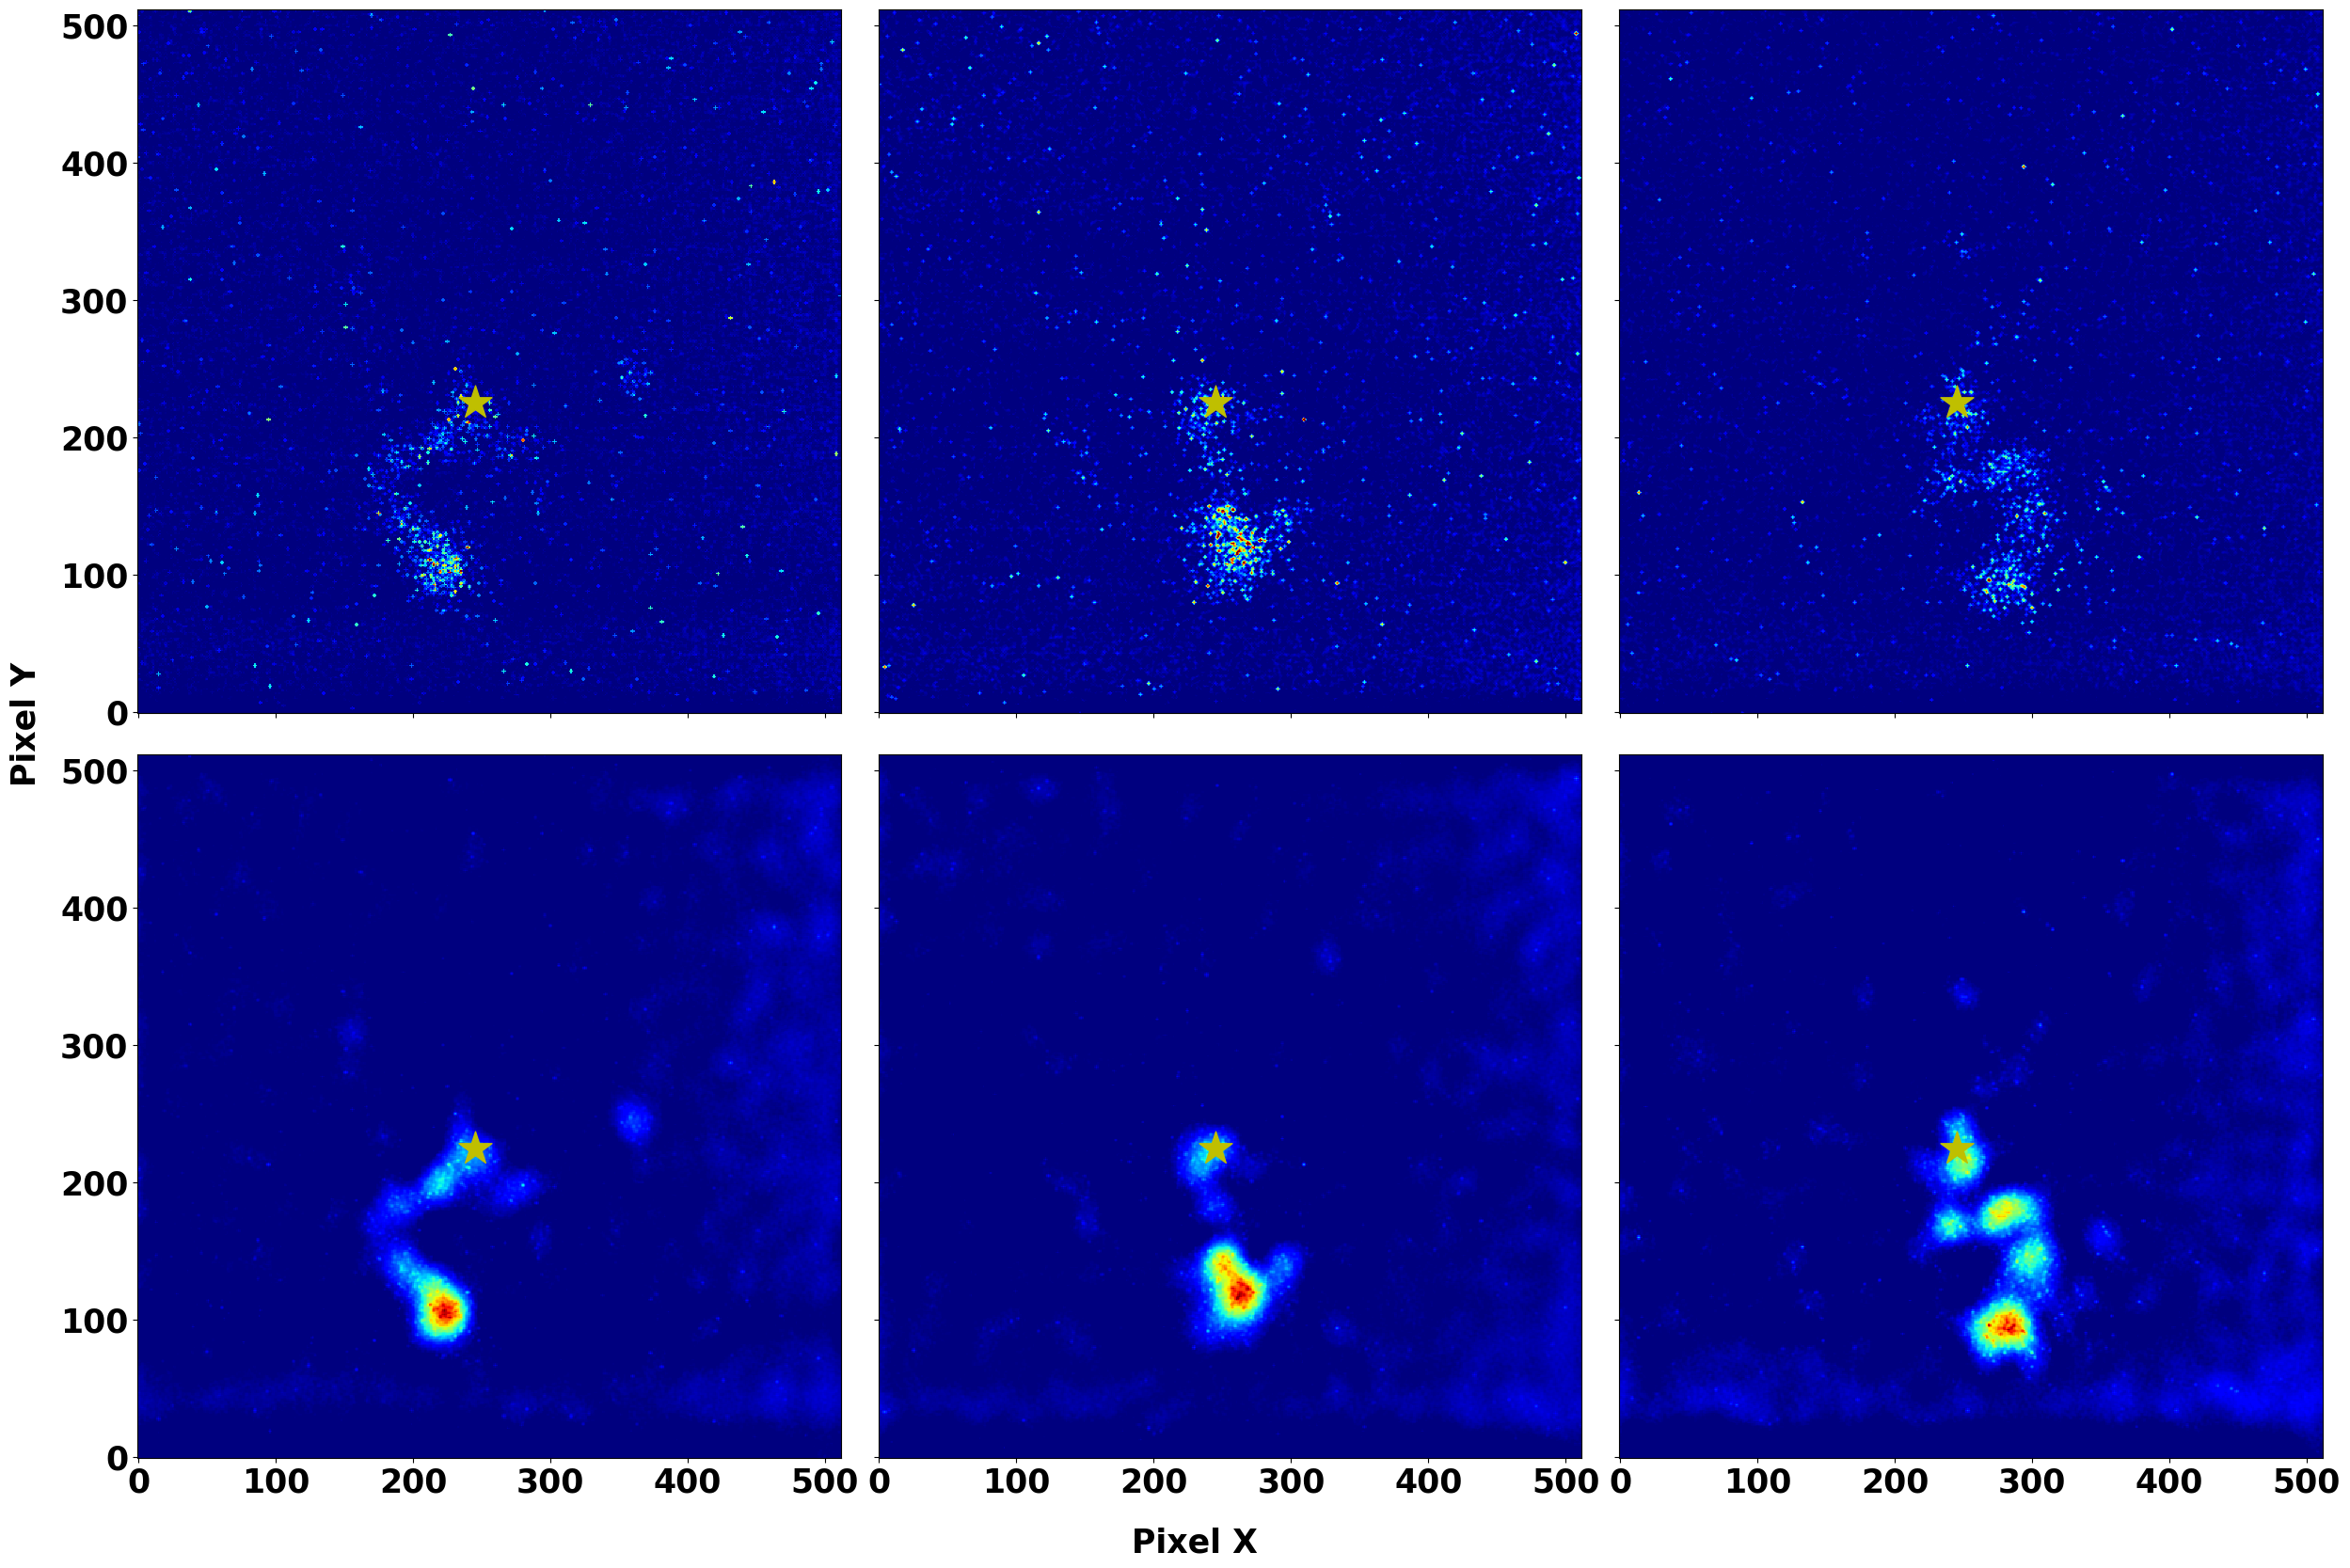

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 20), sharex=True, sharey=True)

fig.text(0.5, 0.06, 'Pixel X', ha='center')
fig.text(0.08, 0.5, 'Pixel Y', va='center', rotation='vertical')

#### alphas
ax[0][0].imshow(Events["Betas"][0],cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(Events["Betas"][0])), vmax=np.max(Events["Betas"])*0.95)
ax[0][1].imshow(Events["Betas"][1],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Betas"][1])), vmax=np.max(Events["Betas"][1])*0.95)
ax[0][2].imshow(Events["Betas"][2],cmap=plt.get_cmap('jet'),origin="lower",vmin=(np.mean(Events["Betas"][2])), vmax=np.max(Events["Betas"][2])*0.95)
for i in range(0,3):
    ax[0][i].scatter([245],[225],s=700,color="y",marker="*")
fftimg=np.fft.fft2(Events["Betas"][0])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][0].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Betas"][1])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][1].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))
fftimg=np.fft.fft2(Events["Betas"][2])
restored2DWiener = (fftimg*Events["WienerandLowPass"])
restored2DWiener = np.fft.ifft2(restored2DWiener)
restored2DWiener = np.real(restored2DWiener)
ax[1][2].imshow(restored2DWiener,cmap=plt.get_cmap('jet'),origin="lower", interpolation='nearest',vmin=(np.mean(restored2DWiener)), vmax=np.max(restored2DWiener))

for i in range(0,3):
    ax[1][i].scatter([245],[225],s=700,color="y",marker="*")

plt.subplots_adjust(wspace=0.05, hspace=0.06)
#fig.savefig("/home/ilker/Desktop/CRAB/Betas.png",bbox_inches='tight')

